# 加载图像数据集

`Linux` `Ascend` `GPU` `CPU` `数据准备` `初级` `中级` `高级`

[![](https://gitee.com/mindspore/docs/raw/r1.5/resource/_static/logo_source.png)](https://gitee.com/mindspore/docs/blob/r1.5/docs/mindspore/programming_guide/source_zh_cn/load_dataset_image.ipynb)&emsp;
[![](https://gitee.com/mindspore/docs/raw/r1.5/resource/_static/logo_notebook.png)](https://obs.dualstack.cn-north-4.myhuaweicloud.com/mindspore-website/notebook/r1.5/programming_guide/zh_cn/mindspore_load_dataset_image.ipynb)&emsp;
[![](https://gitee.com/mindspore/docs/raw/r1.5/resource/_static/logo_modelarts.png)](https://authoring-modelarts-cnnorth4.huaweicloud.com/console/lab?share-url-b64=aHR0cHM6Ly9taW5kc3BvcmUtd2Vic2l0ZS5vYnMuY24tbm9ydGgtNC5teWh1YXdlaWNsb3VkLmNvbS9ub3RlYm9vay9tYXN0ZXIvcHJvZ3JhbW1pbmdfZ3VpZGUvemhfY24vbWluZHNwb3JlX2xvYWRfZGF0YXNldF9pbWFnZS5pcHluYg==&imageid=65f636a0-56cf-49df-b941-7d2a07ba8c8c)&emsp;

## 概述

在计算机视觉任务中，图像数据往往因为容量限制难以直接全部读入内存。MindSpore提供的`mindspore.dataset`模块可以帮助用户构建数据集对象，分批次地读取图像数据。同时，在各个数据集类中还内置了数据处理和数据增强算子，使得数据在训练过程中能够像经过pipeline管道的水一样源源不断地流向训练系统，提升数据训练效果。

此外，MindSpore还支持分布式场景数据加载，用户可以在加载数据集时指定分片数目，具体用法参见[数据并行模式加载数据集](https://www.mindspore.cn/docs/programming_guide/zh-CN/r1.5/distributed_training_ascend.html#id6)。

**本教程将以加载[MNIST训练数据集[1]](#参考文献)为例，演示如何使用MindSpore加载和处理图像数据。**

## 准备环节

### 导入模块

该模块提供API以加载和处理数据集。

In [1]:
import mindspore.dataset as ds

### 下载所需数据集

下载数据集存放在`./datasets/MNIST_Data`路径中，目录结构如下:

```text
./datasets/MNIST_Data
├── test
│   ├── t10k-images-idx3-ubyte
│   └── t10k-labels-idx1-ubyte
└── train
    ├── train-images-idx3-ubyte
    └── train-labels-idx1-ubyte
```
在Jupyter Notebook中运行以下命令来下载MNIST数据集的训练图像和标签：

In [ ]:
!mkdir -p ./datasets/MNIST_Data/train ./datasets/MNIST_Data/test
!wget -NP ./datasets/MNIST_Data/train https://mindspore-website.obs.myhuaweicloud.com/notebook/datasets/mnist/train-labels-idx1-ubyte --no-check-certificate 
!wget -NP ./datasets/MNIST_Data/train https://mindspore-website.obs.myhuaweicloud.com/notebook/datasets/mnist/train-images-idx3-ubyte --no-check-certificate
!wget -NP ./datasets/MNIST_Data/test https://mindspore-website.obs.myhuaweicloud.com/notebook/datasets/mnist/t10k-labels-idx1-ubyte --no-check-certificate
!wget -NP ./datasets/MNIST_Data/test https://mindspore-website.obs.myhuaweicloud.com/notebook/datasets/mnist/t10k-images-idx3-ubyte --no-check-certificate

## 加载数据集

MindSpore目前支持加载图像领域常用的经典数据集和多种数据存储格式下的数据集，用户也可以通过构建自定义数据集类实现自定义方式的数据加载。各种数据集的详细加载方法，可参考编程指南中[数据集加载](https://www.mindspore.cn/docs/programming_guide/zh-CN/r1.5/dataset_loading.html)章节。

下面演示使用`mindspore.dataset`模块中的`MnistDataset`类加载MNIST训练数据集。

1. 配置数据集目录，创建MNIST数据集对象。

In [3]:
DATA_DIR = './datasets/MNIST_Data/train'
mnist_dataset = ds.MnistDataset(DATA_DIR, num_samples=6, shuffle=False)

2. 创建字典迭代器，通过迭代器获取一条数据，并将数据进行可视化。

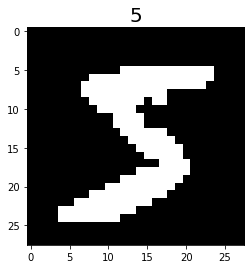

In [4]:
import matplotlib.pyplot as plt

mnist_it = mnist_dataset.create_dict_iterator()
data = next(mnist_it)
plt.imshow(data['image'].asnumpy().squeeze(), cmap=plt.cm.gray)
plt.title(data['label'].asnumpy(), fontsize=20)
plt.show()

此外，用户还可以在数据集加载时传入`sampler`参数用来指定数据采样方式。MindSpore目前支持的数据采样器及其详细使用方法，可参考编程指南中[采样器](https://www.mindspore.cn/docs/programming_guide/zh-CN/r1.5/sampler.html)章节。

## 数据处理

MindSpore目前支持的数据处理算子及其详细使用方法，可参考编程指南中[数据处理](https://www.mindspore.cn/docs/programming_guide/zh-CN/r1.5/pipeline.html)章节。

下面演示构建pipeline，对MNIST数据集进行`shuffle`、`batch`、`repeat`等操作。

操作前的数据如下：

In [5]:
for data in mnist_dataset.create_dict_iterator():
    print(data['label'])

5
0
4
1
9
2


1. 对数据进行混洗。

In [6]:
ds.config.set_seed(58)
ds1 = mnist_dataset.shuffle(buffer_size=6)

print('after shuffle: ')
for data in ds1.create_dict_iterator():
    print(data['label'])

after shuffle: 
4
2
1
0
5
9


2. 对数据进行分批。

In [7]:
ds2 = ds1.batch(batch_size=2)

print('after batch: ')
for data in ds2.create_dict_iterator():
    print(data['label'])

after batch: 
[4 2]
[1 0]
[5 9]


3. 对pipeline操作进行重复。

In [8]:
ds3 = ds2.repeat(count=2)

print('after repeat: ')
for data in ds3.create_dict_iterator():
    print(data['label'])

after repeat: 
[4 2]
[1 0]
[5 9]
[2 4]
[0 9]
[1 5]


可以看到，数据集被扩充成两份，且第二份数据的顺序与第一份不同。因为`repeat`将对整个数据处理pipeline中已经定义的操作进行重复，而不是单纯将此刻的数据进行复制，故第二份数据执行`shuffle`后与第一份数据顺序不同。

另外，需要注意repeat和batch操作的先后顺序: 1) 通常batch操作在repeat操作之前进行。2) 如果batch操作在repeat操作之后，则batch操作会将两个epoch之间的数据batch到一起（在一些情形下互换batch和repeat的顺序会引起dataset中包含的batch数不一致，因batch算子初始化包含drop_reminder参数，默认为False）。

## 数据增强

MindSpore目前支持的数据增强算子及其详细使用方法，可参考编程指南中[数据增强](https://www.mindspore.cn/docs/programming_guide/zh-CN/r1.5/augmentation.html)章节。

下面演示使用`c_transforms`模块对MNIST数据集进行数据增强。

1. 导入相关模块，重新加载数据集。

In [9]:
from mindspore.dataset.vision import Inter
import mindspore.dataset.vision.c_transforms as transforms

mnist_dataset = ds.MnistDataset(DATA_DIR, num_samples=6, shuffle=False)

2. 定义数据增强算子，对数据集执行`Resize`和`RandomCrop`操作。

In [10]:
resize_op = transforms.Resize(size=(200,200), interpolation=Inter.LINEAR)
crop_op = transforms.RandomCrop(150)
transforms_list = [resize_op, crop_op]
ds4 = mnist_dataset.map(operations=transforms_list,input_columns='image')

3. 查看数据增强效果。

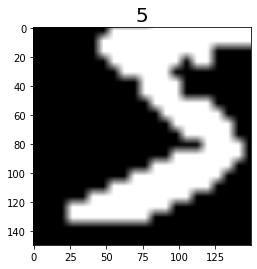

In [11]:
mnist_it = ds4.create_dict_iterator()
data = next(mnist_it)
plt.imshow(data['image'].asnumpy().squeeze(), cmap=plt.cm.gray)
plt.title(data['label'].asnumpy(), fontsize=20)
plt.show()

可以看到，原始图片经缩放后被随机裁剪至150x150大小。

## 参考文献

[1] Y. LeCun, L. Bottou, Y. Bengio, and P. Haffner. [Gradient-based learning applied to document recognition](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf).